# Обработка отзывов о мобильных телефонах - ч.2

Дано: датасет с русскоязычными отзывами о мобильных телефонах с выставленным рейтингом от 1 до 5.
В настоящем ноутбуке представлено решение задачи мультиклассовой классификации отзывов при помощи нейросетей.
Метрика: МАЕ <= 1.0

# Предварительная обработка текстов

## Установка библиотек

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
from catboost import EFstrType
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from math import sqrt
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
nltk.download('punkt')
from nltk import tokenize
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from pymystem3 import Mystem
mystem_analyzer = Mystem()
import re
from tqdm import tqdm
from pymorphy3 import MorphAnalyzer
tqdm.pandas()
morph = MorphAnalyzer()
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\term\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\term\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\term\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
from string import punctuation
from collections import Counter

from fastai.text.all import *
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.tracker import EarlyStoppingCallback


In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

In [7]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of CUDA devices:", torch.cuda.device_count())


Torch version: 2.3.0+cpu
CUDA available: False
CUDA version: None
Number of CUDA devices: 0


## Константы

In [8]:
LOCAL_PATH = 'D:/_DS/Edu/NLP_1_flow/Homework_1/'
RANDOM_STATE = RS = 654321
TEST_SIZE = .25
# выделение в тексте
BOLD = "\033[1m"
ITALIC = "\033[3m"
END = "\033[0m"
CR = '\n'

## Вспомогательные функции

In [9]:
# Функция, выводящая основную информацию о датафрейме
def about_df(data, size=5):
    print (BOLD + 'Изучим исходные данные' + END)
    print(data.info())
    print(BOLD + CR + f'Вывод первых {size} строк датафрейма:' + END)
    display(data.head(size))
    print(BOLD + CR + 'Вывод основной информации о датафрейме:' + END)
    print(CR + 'Количество строк: ', data.shape[0])
    print('Количество столбцов: ', data.shape[1])
    categ_col = data.columns[data.dtypes == 'object']
    num_col = data.columns[data.dtypes != 'object']
    print('Количество категориальных признаков: ', len(categ_col))
    print('Количество числовых признаков: ', len(num_col))
    missed_cells = data.isna().sum().sum()/(data.shape[0]*(data.shape[1]-1))
    missed_rows = sum(data.isna().sum(axis = 1)>0)/data.shape[0]
    print (BOLD + CR + 'Проверка пропусков'+ END)
    print ('Количество пропусков: {:.0f}'.format(data.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ END)
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))
    print(BOLD +  CR + 'Описание количественных данных:'+ END)
    display(pd.concat([pd.DataFrame(np.array([data[num_col].isna().sum(), data[num_col].isna().mean()*100]).T,
                                columns=['кол-во пропусков', 'доля пропусков, %'], index=data[num_col].columns), data.describe().T], axis=1))
    print(BOLD + CR + 'Описание категориальных данных:'+ '\033[0m')
    display(pd.concat([pd.DataFrame(np.array([data[categ_col].isna().sum(), data[categ_col].isna().mean()*100]).T,
                                columns=['кол-во пропусков', 'доля пропусков, %'], index=data[categ_col].columns), data.describe(include='object').T], axis=1))
    ## Проверим дубликаты
    print (BOLD +  CR + 'Проверка на дубликаты'+ END)
    print('Количество полных дубликатов: ', data.duplicated().sum())
        

## Чтение данных

Наши данные выгружены в текстовом виде. Посмотрим на них:

In [10]:
with open(LOCAL_PATH + 'data_processed.csv', 'r', encoding='utf-8')as f:
    comments_text = f.read()
comments_text[:1500]

'processed,Rating\nd touch просто восхитительный вещь ! заряд держать целый день в розовый цвет смотреться очень необычно touch id очень быстрый удобный весь советовать телефон !,5\nотключаться температура близкий нуль непонятно вести батарея,4\nв apple окончательно решить не заморачиваться делать незначительный изменение телефон выдавать изменение инновация на скопировать не функционал дизайн цена неадекватно завысить скачок курс говорить не приходиться многие сказать hd разрешение достаточно диагональ оно аппарат позиционироваться топовый решение итог получать банальный экономия производитель произойти время работа увеличить fhd ! гб оперативка прошлый век ! и не рассказывать сказка великолепный оптимизация ios чудо свет не бывать мало тот сказать не волновать технический характеристика смартфон главное хорошо работать телефон хорошо работать отдавать выбрасывать нужно думать голова понимать этот деньга данный телефон просто непросто не стоить ! про удобство использование стоить отме

Обработанный датасет выглядит прекрасно - леммы, всё строчными, готов к работе. Код ниже - как его получали.

In [11]:
with open(LOCAL_PATH + 'data.csv', 'r', encoding='utf-8')as f:
    comments_text = f.read()
comments_text[:1500]

'Review,Rating\n3D Touch просто восхитительная вещь! Заряд держит целый день. В розовом цвете смотрится очень необычно. Touch ID очень быстрый и удобный. Всем советую этот телефон!,5\n"Отключается при температуре близкой к нулю, непонятно ведет себя батарея",4\n"В Apple окончательно решили не заморачиваться, делая незначительные изменения в телефоне, выдают эти изменения за инновации. На этот раз скопировали не только функционал, но и дизайн. Цена и была неадекватно завышена, а после скачка курса так и говорить об этом не приходится. Многие скажут, что и HD разрешения будет достаточно для такой диагонали, может так оно и есть, но аппарат позиционируется, как топовое решение, а в итоге получаем банальную экономию производителя, ведь что произойдёт с временем работы, если увеличить до FHD?! 1 гб оперативки тоже прошлый век! И не надо рассказывать сказки про великолепную оптимизацию iOS, чудес на свете не бывает, этого мало. Те кто скажет, что их не волнуют технические характеристики смар

Так, разделитель - запятая, 2 колонки, отзыв и рейтинг. Анализ сделан в части один, здесь просто подготовим датасет. Подготовка разными способами для двух нейросетей.

Подготовка данных стандартная:

In [12]:
data = pd.read_csv(LOCAL_PATH + 'data.csv', sep=',')

In [13]:
data_processed = pd.read_csv(LOCAL_PATH + 'data_processed.csv', sep=',')

In [14]:
#Если что-то пошло не так
#data = data_processed

In [15]:
data_processed[data_processed.isna()]['Rating'].value_counts()

Series([], Name: count, dtype: int64)

In [16]:
data_processed = data_processed.dropna().reset_index(drop = True)

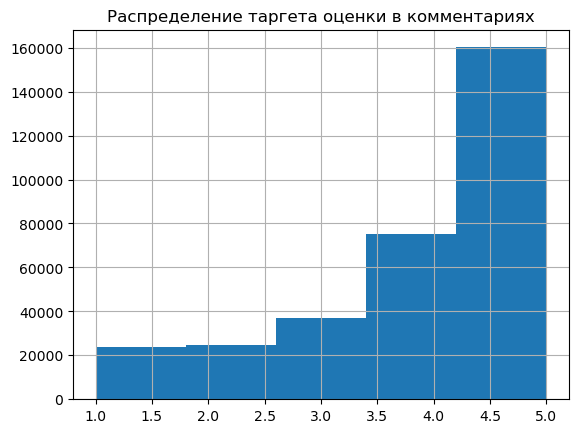

In [17]:
data = data.dropna().reset_index(drop = True)
data = data.drop_duplicates()
data.loc[data['Rating']==7, 'Rating'] = 5
data = data[data['Rating']<9]
data = data[data['Rating']>0]
pd.Series(data['Rating']).hist( bins = 5)
plt.title('Распределение таргета оценки в комментариях')
plt.show()

In [18]:
dls = TextDataLoaders.from_df(data_processed, text_col='processed', 
                               label_col='Rating', valid_pct=0.2)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `n_workers` has to be changed to 0 to avoid getting stuck


## Создание модели на RNN AWD_LSTM

Воспользуемся fastai, чтобы получить готовое решение из коробки для бэйзлайна.

In [103]:
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5,metrics=[accuracy, Precision(average='weighted'), 
                                                                      Recall(average='weighted'), F1Score(average='weighted')])


AWD-LSTM - это тип рекуррентной нейронной сети (RNN), которую разработали Мерити и соавторы. Название "AWD-LSTM" происходит от "ASGD Weight-Dropped LSTM", где ASGD обозначает Average Stochastic Gradient Descent, а "Weight-Dropped" относится к специальной технике регуляризации, используемой в этой модели.

drop_mult - это коэффициент, контролирующий уровень dropout, применяемый к различным слоям сети. Dropout - техника регуляризации, при которой во время обучения случайным образом "выключаются" или "отбрасываются" некоторые нейроны, чтобы предотвратить переобучение. Коэффициент drop_mult применяется к базовым ставкам dropout, определенным в модели. Значение drop_mult=0.5 означает, что ставки dropout будут в половину базовых ставок.

Изменение значения drop_mult может влиять на производительность модели. Более высокие значения (ближе к 1 или больше) увеличивают уровень dropout и могут помочь предотвратить переобучение, но также могут привести к недообучению. Более низкие значения (ближе к 0) уменьшают уровень dropout, позволяя модели выучивать более сложные шаблоны в данных, но увеличивая риск переобучения.

In [104]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.321225,1.324547,0.497033,0.247041,0.497033,0.330041,43:01


epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,f1_score,time
0,1.305269,1.307089,0.496497,0.262135,0.496497,0.330613,1:55:57
1,1.112469,1.094227,0.532893,0.440918,0.532893,0.439892,2:11:53
2,1.049840,1.017239,0.560644,0.498184,0.560644,0.508265,2:12:11
3,1.024973,0.999439,0.568962,0.510093,0.568962,0.518988,2:12:07
4,1.016919,0.997303,0.570678,0.515172,0.570678,0.524028,1:53:06


Дообучаем модель с помощью метода fine_tune на 5 эпох. В методе fine_tune, сначала обучается только голова модели (новый слой, добавленный в конец предварительно обученной модели) на одну эпоху, а затем весь остальной корпус модели на количество эпох, указанных в аргументе (в данном случае - 5).

```
epoch	train_loss	valid_loss	time
0	1.341249	1.305920	1:57:10
1	1.126364	1.085239	1:55:28
2	1.063351	1.027579	1:56:03
3	1.026945	1.006191	1:58:54
```

По итогам четвёртой эпохи лосс и трэйн и валидационный всё ещё хорошо сокращаются. Жду пятую.

Строим графики потерь при обучении и валидации

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

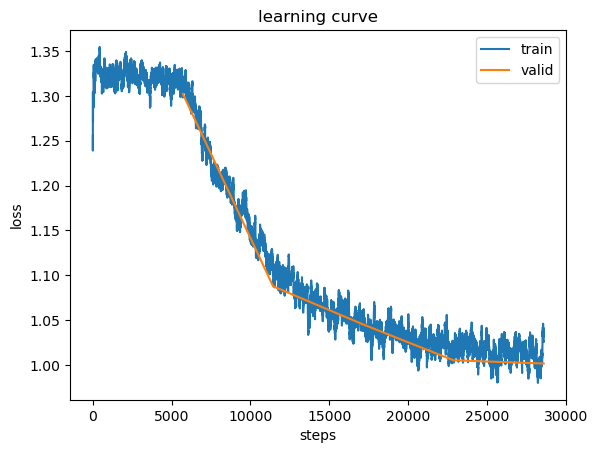

In [21]:
learn.recorder.plot_loss()

Строим графики для расписаний скорости обучения и импульса процесса обучения

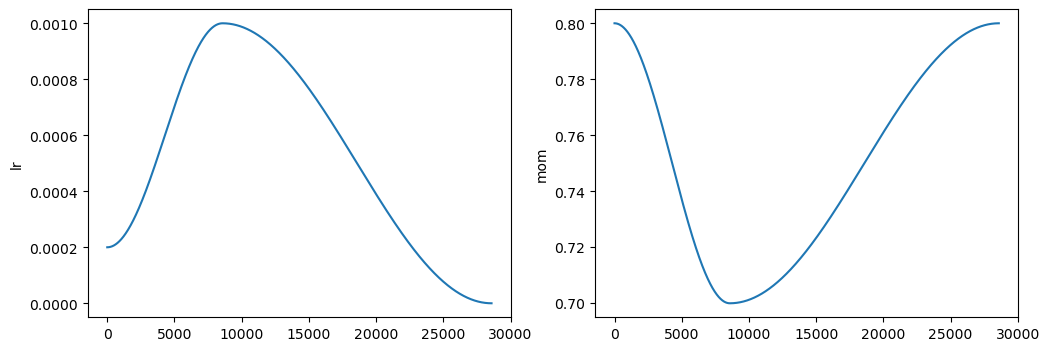

In [22]:
learn.recorder.plot_sched()

Создадим объект ClassificationInterpretation, который можно использовать для интерпретации результатов классификационной модели

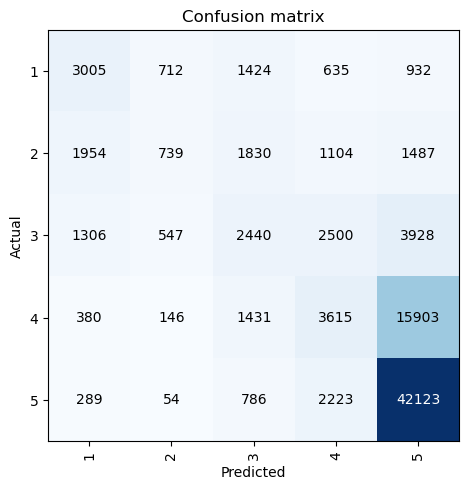

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Посмотрим на некорректные прогнозы вместе с их предсказанными и фактическими метками.

In [24]:
interp.show_results(idxs=[0,1,2,3,4,5,6,7,8,9])


,text,category,category_
0,xxbos отличный смартфон повседневный использование оглядка розетка ! поверьте нужно очень сильно постараться разрядить день если нужный хороший смартфон способный справляться весь задача не лихорадить вид каждый розетка телефон однозначно ваш выбор ! но gps прийтись допиливать сам после два неделя использование отправить обратно магазин экспертиза сила терпеть ужасный поведение gps ! ! ! быть менять тот пора пока не попасться правильный телефон ! другой модель не хотеть просто предел мечтание автономность ! совет весь присматриваться дать модель обязательно проверять работа gps этот функция не нужный смело брать телефон наслаждаться общение игра воистину хороший батарея время автономный работа сегодняшний день среди смартфон ! ! !,4,5
1,xxbos покупать думать очередной ширпотреб нокия вполне приличный телефон именно телефон не компьютер карман очень удобный не смотреть пластмассовость держание рука создавать впечатление хороший качественный вещь ничего не скрипеть не люфтит батарея держать день примерно час звонок около смс немного пользование всякий аська ватсап мр плеер отсутствие юсб компенсироваться возможность синхронизация блютуз контакт так п быстро перекидываться музыка другой объёмный файл долгий телефон сравнивать предыдущий гаджет нокл как кирпич сравнивать xxunk айфон не понимать у разный назначение нокия связь современный телефон розетка считать модель свой деньга стоить покупать доставка,4,5
2,xxbos это первый телефон lenovo по очень удобный продумать пользоваться один удовольствие ни какой сравнение мой бывший филипс w не идти взять телефон р это дорогой заказывать китай зато проблема гарантийный ремонт не чехол магнитная разблокировка телефон быть брать китай р стоить р дурд,4,4
3,xxbos у чёрный выглядеть строго стильно в рука лежать удобно звук достаточно громкий экран высота по периметр лицевой панель резиновый рамочка предохранять царапина можно смело положить стол лицо вниз провезти корпус сделать солидно пластик хороший не скрипеть вообще впечатление надёжный аппарат случай жизнь,5,5
4,xxbos телефон жить свой жизнь делать всё независимо ваш желание качать приложение менять заставка перезагружаться в итог постоянно виснуть кушать батарейка полдень врежим ожидание уже искать поменять,2,4
5,xxbos долго решать телефон купить до пользователь айфон не думать понравиться либо телефон андройда ни сколько не пожалеть выбрать именно я свой выбор довольный,5,5
6,xxbos купить декабрь хотеться именно андроид айфон слишком экран маленький цена айфон загнать небо девайс просто супер не пожелела секунда приобрести,5,5
7,xxbos если не хотеть неделя копаться инет исправлять заводский косяк телефон не советовать покупать,3,1
8,xxbos телефон отличный живучий удобный расставаться не хотеться ! ! ! !,5,5
9,xxbos год самсунг не знать далёкий не возникать желание приобретать телефон,3,5


Посмотрим на комменты с наибольшими потерями (наиболее некорректные прогнозы).

In [25]:
interp.plot_top_losses(k=20)

,input,target,predicted,probability,loss
0,xxbos приобрести сегодня данный тело всё ещё не успеть оценить сдохнуть батарея но всё выглядеть очень достойно качество сборка отличный ни скрип люфт всё заявить функция работать исправно верный успеть проверить поставить пара игрушка вроде не тормозить работать это первый андроид кароч весь довольный правда многое не привычно время привыкнуть скайп ещё не ставить отзыв работать всё нормально,1,5,0.8359876871109009,11.011944770812988
1,xxbos недостаток не заморачиваться телефон падать лужа асфальт последок утопить вода минута просушить фен подержать денёк батарея включить работать никакой нарекание ходить неделя телефон офигенный весь советовать,1,5,0.8900154829025269,9.845934867858887
2,xxbos а основное довольный данные аппарат быстрый удобный практичный ! советовать брать ! ! !,1,5,0.8769104480743408,9.379329681396484
3,xxbos в целое свой цена телефон хороший оправдывать соотношение цена качество высота,1,5,0.6013829708099365,9.363227844238281
4,xxbos в целое свой цена телефон хороший оправдывать соотношение цена качество высота,1,5,0.6013829708099365,9.041954040527344
5,xxbos отличный телефон звук камера замечательный очень рада покупка весь советовать,3,5,0.9593111276626587,9.018621444702148
6,xxbos в целое хороший смартфон цена рубль очень довольный !,1,5,0.7492207884788513,8.765374183654785
7,xxbos в общий телефон отличный брать не пожалеть !,1,5,0.9016063809394836,8.585967063903809
8,xxbos очень приятно держать рука изумительный фото,2,5,0.9303763508796692,8.463388442993164
9,xxbos нарекание прошивка цена довольно высокий,1,5,0.854708194732666,8.412015914916992


Отобразим список кортежей, содержащих наиболее смутные категории.

In [26]:
interp.most_confused()

[(4, 5, 15903),
 (3, 5, 3928),
 (3, 4, 2500),
 (5, 4, 2223),
 (2, 1, 1954),
 (2, 3, 1830),
 (2, 5, 1487),
 (4, 3, 1431),
 (1, 3, 1424),
 (3, 1, 1306),
 (2, 4, 1104),
 (1, 5, 932),
 (5, 3, 786),
 (1, 2, 712),
 (1, 4, 635),
 (3, 2, 547),
 (4, 1, 380),
 (5, 1, 289),
 (4, 2, 146),
 (5, 2, 54)]

Это, конечно, и на матрице видно. Но тут отсортированный список, если что-то пропустили взглядом.

In [27]:
preds, targets, losses = learn.get_preds(with_loss=True)

classification_report из sklearn, нужно преобразовать предсказания модели в метки классов. В настоящее время preds представляет собой вероятности классов, поэтому нужно выбрать класс с наибольшей вероятностью для каждого примера.

Выполним преобразование:

In [28]:
preds_class = preds.argmax(dim=1)

In [29]:
print(classification_report(targets, preds_class)) 

              precision    recall  f1-score   support

           0       0.43      0.45      0.44      6708
           1       0.34      0.10      0.16      7114
           2       0.31      0.23      0.26     10721
           3       0.36      0.17      0.23     21475
           4       0.65      0.93      0.77     45475

    accuracy                           0.57     91493
   macro avg       0.42      0.37      0.37     91493
weighted avg       0.50      0.57      0.51     91493



In [30]:
auc_test = roc_auc_score(targets, preds, multi_class='ovr')
print('AUC ROC тест NN: ',auc_test)

AUC ROC тест NN:  0.8151265659048175


In [31]:
mae = mean_absolute_error(targets, preds_class)
print('mae тест NN: ',mae)

mae тест NN:  0.6234356726744122


Ну... не впечатляет, с картинками результат был лучше. Но бэйзлайн создан, да, кстати, а как выглядит финальная сборка? Посмотрим:

In [32]:
learn.summary()

SequentialRNN (Input shape: 64 x 2869)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 61 x 1152      
LSTM                                                           
LSTM                                                           
____________________________________________________________________________
                     64 x 61 x 400       
LSTM                                                           
RNNDropout                                                     
RNNDropout                                                     
RNNDropout                                                     
BatchNorm1d                               2400       True      
Dropout                                                        
____________________________________________________________________________
                     64 x 50             
Linear                                    60000      True      
ReLU                                     

Найдём оптимальный коэффициент обучения, обучая модель в течение нескольких итераций и строя график потерь по отношению к коэффициентам обучения.

Minimum lr: SuggestedLRs(valley=0.0002290867705596611)


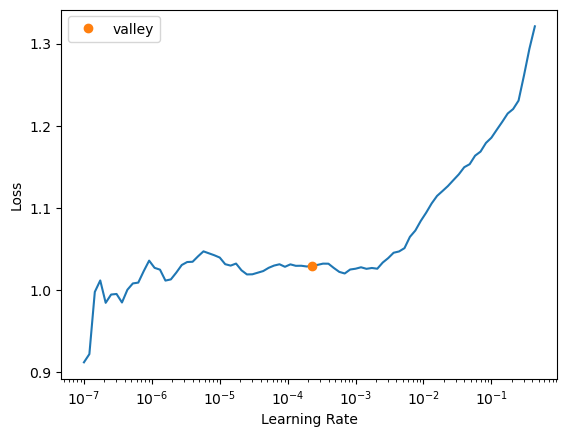

In [33]:
lr_min = learn.lr_find()
print("Minimum lr: " + str(lr_min))

## Шаг 2 подготовка датасета

Нам нужно преобразовать наш текст в векторные представления (эмбеддинги). И для этого нам нужно создать словарь, который сопоставляет каждый токен с идентификаторами.


0. Очистим текст

Проведём удаление: 
ссылок, 
знаков препинания (исключая точку (.), запятую (,), дефис (-), восклицательный знак (!) и вопросительный знак (?))
Удаление HTML-тегов
Пробел между знаками препинания, потому что мы хотим рассматривать некоторые исключенные знаки препинания как отдельные токены.
Удаление номера
Удаление лишних пробелы
Удаление символов nonascii
Удаление смайликов

In [34]:
data.head()

,Review,Rating
0,3D Touch просто восхитительная вещь! Заряд держит целый день. В розовом цвете смотрится очень необычно. Touch ID очень быстрый и удобный. Всем советую этот телефон!,5
1,"Отключается при температуре близкой к нулю, непонятно ведет себя батарея",4
2,"В Apple окончательно решили не заморачиваться, делая незначительные изменения в телефоне, выдают эти изменения за инновации. На этот раз скопировали не только функционал, но и дизайн. Цена и была неадекватно завышена, а после скачка курса так и говорить об этом не приходится. Многие скажут, что и HD разрешения будет достаточно для такой диагонали, может так оно и есть, но аппарат позиционируется, как топовое решение, а в итоге получаем банальную экономию производителя, ведь что произойдёт с временем работы, если увеличить до FHD?! 1 гб оперативки тоже прошлый век! И не надо рассказывать ск...",3
3,"Постарался наиболее ёмко и коротко описать все основные плюсы и минусы. Большим мне аппарат не показался, размеры - что надо. Внешний вид, как для меня, так 5-ка выглядит интереснее и солиднее.",4
4,Достойный телефон. Пользоваться одно удовольствие.,5


In [35]:
def rm_link(text):
    return re.sub(r'https?://\S+|www\.\S+', '', text)

def rm_punct2(text):
    return re.sub(r'[\"\#\$\%\&\'\(\)\*\+\/\:\;\<\=\>\@\[\\\]\^\_\`\{\|\}\~]', ' ', text)

def rm_html(text):
    return re.sub(r'<[^>]+>', '', text)

regex = re.compile("[А-ЯЁа-яёA-Za-z?!]+")
def get_words_only(text, regex=regex):
    return " ".join(regex.findall(text))

def rm_nonascii(text):
    return re.sub(r'[^\x00-\x7f]', r'', text)

def rm_emoji(text):
    emojis = re.compile(
        '['
        u'\U0001F600-\U0001F64F'
        u'\U0001F300-\U0001F5FF'
        u'\U0001F680-\U0001F6FF'
        u'\U0001F1E0-\U0001F1FF'
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE
    )
    return emojis.sub(r'', text)

#def spell_correction(text):
#    return re.sub(r'(.)\1+', r'\1\1', text)

def clean_pipeline(text):    
    no_link = rm_link(text)
#    no_html = rm_html(no_link)
#    space_punct = space_bt_punct(no_html)
#    no_punct = rm_punct2(no_html)
#    no_number = rm_number(no_punct)
#    no_whitespaces = rm_whitespaces(no_number)
#    no_nonasci = rm_nonascii(no_punct)
#    no_emoji = rm_emoji(no_nonasci)
    words_only = get_words_only(no_link)
    return words_only

data['clean'] = data['Review'].progress_apply(clean_pipeline)

100%|███████████████████████████████████████████████████████████████████████| 321099/321099 [00:04<00:00, 72968.21it/s]


In [36]:
data['clean'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                           D Touch просто восхитительная вещь! Заряд держит целый день В розовом цвете смотрится очень необычно Touch ID очень быстрый и удобный Всем советую этот телефон!
1                                                                                                                                                                                                                                                                                                                                                                                                          

Очистив текст, перейдем к предварительной обработке:

Токенизация, где мы разбиваем текст по словам с помощью пакета nltk. 
Удаляем стоп-слова. Здесь мы будем использовать стоп-слова, предоставленные nltk. 
Лемматизация, когда мы преобразуем слова в их первоначальную форму, удаляя их суффикс.

In [37]:
noise = stopwords.words('russian') + list(punctuation)+ ['``', "''",'--',"//", '/']
len(noise)
excl_list = ['хорошо', 'не', 'никогда','ничего', "!", 'нельзя' ]
noise = [x for x in noise if x not in  excl_list]
len(noise)

182

In [38]:
def tokenize(text):
    return word_tokenize(text)

def rm_stopwords(text):
    return [i for i in text if i not in noise]


def lemmatize_it(text):
    lemmas = [morph.parse(word)[0].normal_form for word in text]
    lemmatized_text = ' '.join(lemmas)
    return  lemmatized_text

#def lemmatize(text):
#    lemmatizer = WordNetLemmatizer()    
#    lemmas = [lemmatizer.lemmatize(t) for t in text]
    # make sure lemmas does not contains sotpwords
#    return rm_stopwords(lemmas)

def preprocess_pipeline(text):
    tokens = tokenize(text)
    no_stopwords = rm_stopwords(tokens)
    lemmas = lemmatize_it(no_stopwords)
    return lemmas


data['processed'] = data['clean'].progress_apply(preprocess_pipeline)

100%|█████████████████████████████████████████████████████████████████████████| 321099/321099 [19:28<00:00, 274.70it/s]


In [39]:
data['processed'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                            d touch просто восхитительный вещь ! заряд держать целый день в розовый цвет смотреться очень необычно touch id очень быстрый удобный весь советовать телефон !
1                                                                                                                                                                                                                                                                                                                                                                                                          

сохраняем предобработанный набор данных в новый CSV-файл для дальнейшего использования.

In [40]:
data[['processed', 'Rating']].to_csv(LOCAL_PATH +'data_processed.csv', index=False, header=True)

In [41]:
#data = pd.read_csv(LOCAL_PATH +'data_processed.csv')
data.head()

,Review,Rating,clean,processed
0,3D Touch просто восхитительная вещь! Заряд держит целый день. В розовом цвете смотрится очень необычно. Touch ID очень быстрый и удобный. Всем советую этот телефон!,5,D Touch просто восхитительная вещь! Заряд держит целый день В розовом цвете смотрится очень необычно Touch ID очень быстрый и удобный Всем советую этот телефон!,d touch просто восхитительный вещь ! заряд держать целый день в розовый цвет смотреться очень необычно touch id очень быстрый удобный весь советовать телефон !
1,"Отключается при температуре близкой к нулю, непонятно ведет себя батарея",4,Отключается при температуре близкой к нулю непонятно ведет себя батарея,отключаться температура близкий нуль непонятно вести батарея
2,"В Apple окончательно решили не заморачиваться, делая незначительные изменения в телефоне, выдают эти изменения за инновации. На этот раз скопировали не только функционал, но и дизайн. Цена и была неадекватно завышена, а после скачка курса так и говорить об этом не приходится. Многие скажут, что и HD разрешения будет достаточно для такой диагонали, может так оно и есть, но аппарат позиционируется, как топовое решение, а в итоге получаем банальную экономию производителя, ведь что произойдёт с временем работы, если увеличить до FHD?! 1 гб оперативки тоже прошлый век! И не надо рассказывать ск...",3,В Apple окончательно решили не заморачиваться делая незначительные изменения в телефоне выдают эти изменения за инновации На этот раз скопировали не только функционал но и дизайн Цена и была неадекватно завышена а после скачка курса так и говорить об этом не приходится Многие скажут что и HD разрешения будет достаточно для такой диагонали может так оно и есть но аппарат позиционируется как топовое решение а в итоге получаем банальную экономию производителя ведь что произойдёт с временем работы если увеличить до FHD?! гб оперативки тоже прошлый век! И не надо рассказывать сказки про великол...,в apple окончательно решить не заморачиваться делать незначительный изменение телефон выдавать изменение инновация на скопировать не функционал дизайн цена неадекватно завысить скачок курс говорить не приходиться многие сказать hd разрешение достаточно диагональ оно аппарат позиционироваться топовый решение итог получать банальный экономия производитель произойти время работа увеличить fhd ! гб оперативка прошлый век ! и не рассказывать сказка великолепный оптимизация ios чудо свет не бывать мало тот сказать не волновать технический характеристика смартфон главное хорошо работать телефон х...
3,"Постарался наиболее ёмко и коротко описать все основные плюсы и минусы. Большим мне аппарат не показался, размеры - что надо. Внешний вид, как для меня, так 5-ка выглядит интереснее и солиднее.",4,Постарался наиболее ёмко и коротко описать все основные плюсы и минусы Большим мне аппарат не показался размеры что надо Внешний вид как для меня так ка выглядит интереснее и солиднее,постараться наиболее ёмко коротко описать основной плюс минус больший аппарат не показаться размер внешний вид ка выглядеть интересный солидный
4,Достойный телефон. Пользоваться одно удовольствие.,5,Достойный телефон Пользоваться одно удовольствие,достойный телефон пользоваться один удовольствие


## Очистка текста

1. Создадим словарь

In [42]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()

words[:10]

['d',
 'touch',
 'просто',
 'восхитительный',
 'вещь',
 '!',
 'заряд',
 'держать',
 'целый',
 'день']

используем встроенную библиотеку python Counter, чтобы получить и подсчитать количество уникальных слов в отзывах. Затем индексируем наши уникальные слова с 1, потому что мы будем использовать индекс 0 для заполнения токена \<PAD>

In [43]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

2. Закодируем отзывы

Закодируем отзывы, преобразовав каждый токен в соответствующий индекс в словаре, который мы только что создали.

In [44]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

for i in range(10):
    print(reviews_enc[i][:5])

100%|███████████████████████████████████████████████████████████████████████| 321099/321099 [00:03<00:00, 99418.04it/s]

[672, 1647, 18, 5545, 420]
[1049, 2263, 863, 2523, 1387]
[7, 625, 1973, 156, 1]
[1818, 2873, 20607, 4339, 829]
[263, 2, 15, 43, 679]
[48, 5211, 768]
[50, 44, 118, 65, 568]
[36, 5, 124, 103, 25]
[375, 34, 15, 172, 48]
[395, 181, 345, 4270, 4986]


3. Дополним короткие обзоры и обрежем длинные отзывы


мы успешно преобразовали токены в соответствующие идентификаторы.
Но есть другая проблема: длина обзора иногда бывает разной. Нужно определить максимальную длину последовательности. Затем для каждого обзора, длина которого меньше предопределенной длины последовательности, мы добавим токен padding. В противном случае мы будем обрезать (trim) отзывы.

In [45]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, pad_id=word2int['<PAD>'], seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  672,  1647,    18,  5545,   420,     3,   148,    63,   667,
           13],
       [ 1049,  2263,   863,  2523,  1387,  1390,    26,     0,     0,
            0],
       [    7,   625,  1973,   156,     1,  2146,   123,  1996,  1747,
            2],
       [ 1818,  2873, 20607,  4339,   829,   637,   130,   129,   154,
           10],
       [  263,     2,    15,    43,   679,     0,     0,     0,     0,
            0],
       [   48,  5211,   768,     0,     0,     0,     0,     0,     0,
            0],
       [   50,    44,   118,    65,   568,  2797,  1208,   377,    39,
            1],
       [   36,     5,   124,   103,    25,     3,     7,    44,   533,
          159],
       [  375,    34,    15,   172,    48,   768,   134,   215,   163,
         5320],
       [  395,   181,   345,  4270,  4986,   115,  2208,   768,    11,
          172]])

И даже здесь видно, как наш короткий отзыв дополнился нулями.

4. Разделим значения выборки на обучение/тест


In [46]:
labels = data.Rating.to_numpy()
labels = labels - 1
labels

array([4, 3, 2, ..., 4, 4, 4], dtype=int64)

Делаем наборы train, validation и test!

In [47]:
train_size = .6
val_size = .5     

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]

split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (192659, 256)
Validation set: (64220, 256)
Test set: (64220, 256)


In [48]:
print(len(train_y[train_y == 1]), len(train_y[train_y == 2]), len(train_y[train_y == 3]), len(train_y[train_y == 4]), len(train_y[train_y == 5]))
print( len(val_y[val_y == 1]), len(val_y[val_y == 2]), len(val_y[val_y == 3]), len(val_y[val_y == 4]), len(val_y[val_y == 5]))
print(len(test_y[test_y == 1]), len(test_y[test_y == 2]), len(test_y[test_y == 3]), len(test_y[test_y == 4]), len(test_y[test_y == 5]))

14550 22017 43764 98545 0
4989 7549 15642 31368 0
5172 7631 15832 30250 0


Соотношения разбились не идеально, но близко

5. Подготовим загрузчик данных и пакеты

передадим наш набор данных в TensorDataset, а затем в DataLoader.

In [49]:
batch_size = 256

trainset = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
validset = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
testset = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

trainloader = DataLoader(trainset, shuffle=True, batch_size=batch_size)
valloader = DataLoader(validset, shuffle=True, batch_size=batch_size)
testloader = DataLoader(testset, shuffle=True, batch_size=batch_size)


Давайте посмотрим на наш только что созданный загрузчик.
Здесь мы ожидаем, что размер X будет (batch_size, sequence_length), а размер Y будет (batch_size)

In [50]:
dataiter = iter(trainloader)
x, y = next(dataiter)

print('Sample batch size: ', x.size()) 
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())
print('Sample label input: \n', y)

Sample batch size:  torch.Size([256, 256])
Sample batch input: 
 tensor([[  347,    40,   193,  ...,     0,     0,     0],
        [    2,    30,   110,  ...,     0,     0,     0],
        [   37,    30,   177,  ...,     0,     0,     0],
        ...,
        [    5,   112,   251,  ...,     0,     0,     0],
        [    9,   998,   680,  ...,     0,     0,     0],
        [   19, 13115,   245,  ...,     0,     0,     0]], dtype=torch.int32)

Sample label size:  torch.Size([256])
Sample label input: 
 tensor([4, 4, 4, 3, 4, 3, 4, 4, 2, 4, 3, 3, 2, 4, 2, 4, 4, 4, 4, 4, 4, 4, 3, 4,
        3, 2, 3, 4, 4, 3, 4, 3, 4, 4, 3, 3, 3, 0, 3, 4, 2, 3, 0, 1, 4, 4, 4, 4,
        0, 2, 1, 1, 4, 2, 4, 4, 0, 4, 0, 4, 4, 3, 3, 4, 4, 4, 4, 3, 1, 4, 4, 3,
        4, 3, 3, 4, 4, 2, 4, 4, 4, 4, 2, 4, 2, 3, 4, 4, 2, 4, 4, 4, 2, 4, 4, 4,
        3, 0, 4, 4, 4, 4, 0, 4, 1, 0, 3, 2, 2, 4, 4, 4, 4, 4, 3, 2, 4, 3, 3, 0,
        4, 4, 4, 2, 4, 3, 1, 2, 2, 3, 4, 4, 3, 4, 1, 4, 1, 2, 4, 4, 4, 4, 2, 2,
        4, 3,

## True CNN

Будем использовать модель на основе CNN. EDA мы делали в прошлой части, есть дубликаты. Но в остальном наш датасет подготовлен

Попробуем обучить простую CNN на векторах слов. С учётом того, что в коллекции 100К уникальных слов, и векторы получатся достаточно громоздкие, урежем коллекцию до 25К слов, для всех прочих заведя токен unk (unknown). Oбучающий сет у нас уже подготовлен и разбит.
Опишем функцию подсчёта accuracy, а также функции обучения и применения сети:

In [62]:
reviews = data.processed.values
words = ' '.join(reviews)
words = words.split()

words[:10]

['d',
 'touch',
 'просто',
 'восхитительный',
 'вещь',
 '!',
 'заряд',
 'держать',
 'целый',
 'день']

In [63]:
counter = Counter(words)
vocab = sorted(counter, key=counter.get, reverse=True)
int2word = dict(enumerate(vocab, 1))
int2word[0] = '<PAD>'
word2int = {word: id for id, word in int2word.items()}

In [64]:
# Кодируем отзывы на основе полученного словаря

In [65]:
reviews_enc = [[word2int[word] for word in review.split()] for review in tqdm(reviews)]

for i in range(5):
    print(reviews_enc[i][:5])

100%|███████████████████████████████████████████████████████████████████████| 321099/321099 [00:03<00:00, 92785.35it/s]

[672, 1647, 18, 5545, 420]
[1049, 2263, 863, 2523, 1387]
[7, 625, 1973, 156, 1]
[1818, 2873, 20607, 4339, 829]
[263, 2, 15, 43, 679]


In [66]:
def pad_features(reviews, pad_id, seq_length=128):
    features = np.full((len(reviews), 
                        seq_length), 
                       pad_id, 
                       dtype=int)

    for i, row in enumerate(reviews):
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 256
features = pad_features(reviews_enc, 
                        pad_id=word2int['<PAD>'], 
                        seq_length=seq_length)

assert len(features) == len(reviews_enc)
assert len(features[0]) == seq_length

features[:10, :10]

array([[  672,  1647,    18,  5545,   420,     3,   148,    63,   667,
           13],
       [ 1049,  2263,   863,  2523,  1387,  1390,    26,     0,     0,
            0],
       [    7,   625,  1973,   156,     1,  2146,   123,  1996,  1747,
            2],
       [ 1818,  2873, 20607,  4339,   829,   637,   130,   129,   154,
           10],
       [  263,     2,    15,    43,   679,     0,     0,     0,     0,
            0],
       [   48,  5211,   768,     0,     0,     0,     0,     0,     0,
            0],
       [   50,    44,   118,    65,   568,  2797,  1208,   377,    39,
            1],
       [   36,     5,   124,   103,    25,     3,     7,    44,   533,
          159],
       [  375,    34,    15,   172,    48,   768,   134,   215,   163,
         5320],
       [  395,   181,   345,  4270,  4986,   115,  2208,   768,    11,
          172]])

In [67]:
labels = data.Rating.to_numpy()
labels

array([5, 4, 3, ..., 5, 5, 5], dtype=int64)

In [68]:
#from sklearn.preprocessing import OneHotEncoder

# Создаем объект OneHotEncoder
encoder = OneHotEncoder()

# Применяем OneHotEncoder к вектору
labels_onehot = encoder.fit_transform(labels.reshape(-1, 1)).toarray()
 
print(labels_onehot)


[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


Попробуем обучить простую CNN на векторах слов. С учётом того, что в коллекции 100К уникальных слов, и векторы получатся достаточно громоздкие, урежем коллекцию до 25К слов, для всех прочих заведя токен unk (unknown). Кроме того, разобьём обучающий сет на обучение и валидацию для настройки параметров.

In [69]:
train_size = .8
val_size = .2

split_id = int(len(features) * train_size)
train_x, remain_x = features[:split_id], features[split_id:]
#train_y, remain_y = labels_onehot[:split_id], labels_onehot[split_id:]
train_y, remain_y = labels[:split_id], labels[split_id:]
split_val_id = int(len(remain_x) * val_size)
val_x, test_x = remain_x[:split_val_id], remain_x[split_val_id:]
val_y, test_y = remain_y[:split_val_id], remain_y[split_val_id:]

print('Feature Shapes:')
print('===============')
print('Train set: {}'.format(train_x.shape))
print('Validation set: {}'.format(val_x.shape))
print('Test set: {}'.format(test_x.shape))

Feature Shapes:
Train set: (256879, 256)
Validation set: (12844, 256)
Test set: (51376, 256)


In [70]:
print(len(train_y))
print( len(val_y))
print(len(test_y))

256879
12844
51376


Опишем функцию подсчёта mae, а также функции обучения и применения сети:

In [71]:
def calc_mae(preds, y):
    rounded_preds = torch.round(preds)
    mae = torch.mean(torch.abs(rounded_preds - y).float())
    return mae

In [80]:
def train_func(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_mae  = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()

        # predictions = model(batch[0].T.cuda()).squeeze(1)
        predictions = model(batch[0].T).squeeze(1)

        # loss = criterion(predictions.float(), 
        #                  batch[1].float().cuda())
        loss = criterion(predictions.float(), 
                         batch[1].float())
        
        # acc = binary_accuracy(predictions.float(), 
        #                       batch[1].float().cuda())
        mae = calc_mae(predictions.float(), batch[1].float())
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss
        epoch_mae += mae

    return epoch_loss / len(iterator), epoch_mae / len(iterator)


In [82]:
def evaluate_func(model, iterator, criterion):
    epoch_loss = 0
    epoch_mae = 0

    model.eval()

    with torch.no_grad():
        for batch in iterator:
            # predictions = model(batch[0].T.cuda()).squeeze(1)
            predictions = model(batch[0].T).squeeze(1)

            # loss = criterion(predictions.float(), 
            #                  batch[1].float().cuda())
            loss = criterion(predictions.float(), 
                             batch[1].float())
            
            # acc = binary_accuracy(predictions.float(), 
            #                       batch[1].float().cuda())
            mae = calc_mae(predictions.float(), batch[1].float())
            
            epoch_loss += loss
            epoch_mae += mae

    return epoch_loss / len(iterator), epoch_mae / len(iterator)


Мы должны определить какая у нас «самая важная» n-грамма в каждом обзоре.Изначально нам это неизвестно. Посредством обратного распространения ошибки веса фильтров изменяются так, что всякий раз, когда наблюдаются определенные n-граммы, которые очень показательны для оценки тональности, выходной сигнал фильтра имеет «высокое» значение. Это «высокое» значение затем проходит через максимальный уровень пула, если оно является максимальным значением на выходе.

Поскольку наша модель имеет 100 фильтров трех разных размеров, это означает, что у нас есть 300 различных n-грамм, которые модель считает важными. Мы объединяем их в один вектор и пропускаем через линейный слой, чтобы предсказать настроение. Мы можем думать о весах этого линейного слоя как о «взвешивании доказательств» каждого из 300 n-грамм и принятии окончательного решения.

Для создания свёрточного слоя воспользуемся nn.Conv2d, in_channels в нашем случае один (текст), out_channels -- это число число фильтров и размер ядер всех фильтров. Каждый фильтр будет иметь размерность [n x размерность эмбеддинга], где n - размер обрабатываемой n-граммы.

Важно, что предложения имели длину не меньше размера самого большого из используемых фильтров, для этого и добавили пэддинги в самое начало

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, 
                 vocab_size,
                 embedding_dim, 
                 n_filters, 
                 filter_sizes, 
                 output_dim, 
                 dropout):
        
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, 
                                      embedding_dim)
        
        self.conv_0 = nn.Conv2d(in_channels=1, 
                                out_channels=n_filters, 
                                kernel_size=(filter_sizes[0], 
                                             embedding_dim))
        
        self.conv_1 = nn.Conv2d(in_channels=1, 
                                out_channels=n_filters, 
                                kernel_size=(filter_sizes[1], 
                                             embedding_dim))
        
        self.conv_2 = nn.Conv2d(in_channels=1, 
                                out_channels=n_filters, 
                                kernel_size=(filter_sizes[2], 
                                             embedding_dim))
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, 
                            output_dim)
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [sent len, batch size]
        x = x.permute(1, 0)

        #x = [batch size, sent len]
        embedded = self.embedding(x)

        #embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)

        #embedded = [batch size, 1, sent len, emb dim]
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))

        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

        #pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)
    
    

Сейчас мы  используем три фильтра.
Построим словарь и загрузим предобученные эмбеддинги:

In [75]:

batch_size  = 256

trainset = TensorDataset(torch.from_numpy(train_x), 
                         torch.from_numpy(train_y))

validset = TensorDataset(torch.from_numpy(val_x), 
                         torch.from_numpy(val_y))

testset = TensorDataset(torch.from_numpy(test_x), 
                        torch.from_numpy(test_y))

train_iterator = DataLoader(trainset, 
                            shuffle=True, 
                            batch_size=batch_size)

valid_iterator = DataLoader(validset, 
                            shuffle=True, 
                            batch_size=batch_size)

test_iterator = DataLoader(testset, 
                           shuffle=True, 
                           batch_size=batch_size)


In [76]:

INPUT_DIM = len(word2int)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5

model = CNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            N_FILTERS, 
            FILTER_SIZES, 
            OUTPUT_DIM, 
            DROPOUT)


In [77]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.8, 0.9), eps=1e-7)
criterion = torch.nn.MSELoss()

#model = model.cuda()
#model = model.to('mps')
model

CNN(
  (embedding): Embedding(112799, 100)
  (conv_0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
  (conv_1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
  (conv_2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [84]:

N_EPOCHS = 10

for epoch in range(N_EPOCHS):
    train_loss, train_mae = train_func(model, 
                                       train_iterator, 
                                       optimizer, 
                                       criterion)
    
    valid_loss, valid_mae = evaluate_func(model, 
                                          valid_iterator, 
                                          criterion)
    
    train_msg = f'Epoch: {epoch+1:02}, '
    train_msg += f'Train Loss: {train_loss:.3f}, '
    train_msg += f'Train Mae: {train_mae*100:.2f}%, '
    train_msg += f'Val. Loss: {valid_loss:.3f}, '
    train_msg += f'Val. Mae: {valid_mae*100:.2f}%'
    
    print(train_msg)
    

Epoch: 01, Train Loss: 0.900, Train Mae: 70.05%, Val. Loss: 0.899, Val. Mae: 74.32%
Epoch: 02, Train Loss: 0.849, Train Mae: 67.40%, Val. Loss: 0.829, Val. Mae: 64.68%
Epoch: 03, Train Loss: 0.808, Train Mae: 65.24%, Val. Loss: 0.816, Val. Mae: 66.33%
Epoch: 04, Train Loss: 0.767, Train Mae: 63.09%, Val. Loss: 0.802, Val. Mae: 64.02%
Epoch: 05, Train Loss: 0.732, Train Mae: 61.09%, Val. Loss: 0.806, Val. Mae: 63.52%
Epoch: 06, Train Loss: 0.700, Train Mae: 59.31%, Val. Loss: 0.792, Val. Mae: 62.64%
Epoch: 07, Train Loss: 0.672, Train Mae: 57.64%, Val. Loss: 0.795, Val. Mae: 62.70%
Epoch: 08, Train Loss: 0.649, Train Mae: 56.23%, Val. Loss: 0.799, Val. Mae: 64.07%
Epoch: 09, Train Loss: 0.632, Train Mae: 55.23%, Val. Loss: 0.791, Val. Mae: 61.60%
Epoch: 10, Train Loss: 0.615, Train Mae: 54.36%, Val. Loss: 0.795, Val. Mae: 61.73%


И получилась какая-то ерунда,  я не смогла настроить мультиклассовый вывод корректно ни в rnn, ни в cnn. Но всё относительно, с другой стороны - метрика растёт, лосс падает ))))))))))))) - учится модель... чему-то.

С третьей эпохи и этому перестала учиться.

In [85]:

test_loss , test_mae = evaluate_func(model, 
                                     test_iterator, 
                                     criterion)

print(f'Test Loss: {test_loss:.3f}, Test Acc: {test_acc*100:.2f}%')


Test Loss: 0.825, Test Acc: 11823.44%


## Общий вывод

По итогу настроен мультиклассовый вывод в rnn и в cnn. 
Для CNN использовался пэддинг с заполнением 0 до нужного размера вектора.
Лучшей моделью в разделе нейросетей стала модель на RNN AWD_LSTM, настроенная fastai. mae тест NN:  0.6234

Модель дообучена с помощью метода fine_tune на 5 эпохах. В методе fine_tune, сначала обучается только голова модели (новый слой, добавленный в конец предварительно обученной модели) на одну эпоху, а затем весь остальной корпус модели на количество эпох, указанных в аргументе (в данном случае - 5).

```
epoch	train_loss	valid_loss	time
0	1.339209	1.325577	39:45
epoch	train_loss	valid_loss	time
0	1.341249	1.305920	1:57:10
1	1.126364	1.085239	1:55:28
2	1.063351	1.027579	1:56:03
3	1.026945	1.006191	1:58:54
4	1.017280	1.000489	1:56:25
```
Ранее модель обучалась на 8 эпохах, но начиная с пятой не показывала улучшения.

Матрица ошибок:
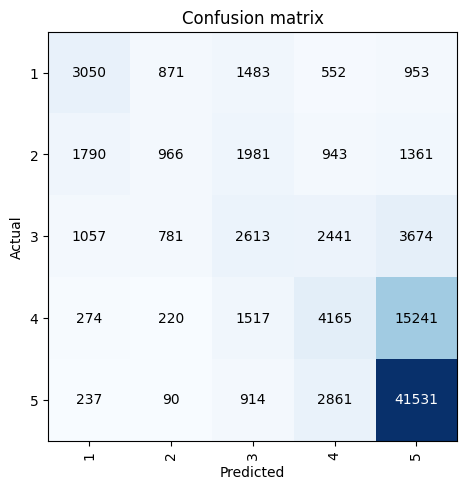

И мы видим, что пятый таргет, которого преизрядно больше, растаскивает всех. Это хорошо видно как на матрице, так и в списке кортежей, содержащих наиболее смутные категории.
```
[(4, 5, 15241),
 (3, 5, 3674),
 (5, 4, 2861),
 (3, 4, 2441),
 (2, 3, 1981),
 (2, 1, 1790),
 (4, 3, 1517),
 (1, 3, 1483),
 (2, 5, 1361),
 (3, 1, 1057),
 (1, 5, 953),
 (2, 4, 943),
 (5, 3, 914),
 (1, 2, 871),
 (3, 2, 781),
 (1, 4, 552),
 (4, 1, 274),
 (5, 1, 237),
 (4, 2, 220),
 (5, 2, 90)]
 ```
 Сильнее всего перепутаны 4 > 5, 3 > 5 и 5> 4.
 
 Меньше всего уходов из 5 и 4 во 2 и из 5 и 4 в первую группы.
 **mae тест NN:  0.6270206463882483**
 
**Summary NN**


```
SequentialRNN (Input shape: 64 x 3046)
============================================================================
Layer (type)         Output Shape         Param #    Trainable 
============================================================================
                     64 x 22 x 1152      
LSTM                                                           
LSTM                                                           
____________________________________________________________________________
                     64 x 22 x 400       
LSTM                                                           
RNNDropout                                                     
RNNDropout                                                     
RNNDropout                                                     
BatchNorm1d                               2400       True      
Dropout                                                        
____________________________________________________________________________
                     64 x 50             
Linear                                    60000      True      
ReLU                                                           
BatchNorm1d                               100        True      
Dropout                                                        
____________________________________________________________________________
                     64 x 5              
Linear                                    250        True      
____________________________________________________________________________

Total params: 62,750
Total trainable params: 62,750
Total non-trainable params: 0

Optimizer used: <function Adam at 0x0000021A730E3060>
Loss function: FlattenedLoss of CrossEntropyLoss()

Model unfrozen

Callbacks:
  - TrainEvalCallback
  - ModelResetter
  - RNNCallback
  - CastToTensor
  - Recorder
  - ProgressCallback
  ```
 И напомню, что нейронки не побили рекорд кэтбуста:
 
 ```
              precision    recall  f1-score   support

           1       0.58      0.62      0.60      8652
           2       0.56      0.37      0.45      8867
           3       0.52      0.43      0.47     13286
           4       0.58      0.42      0.49     26766
           5       0.74      0.89      0.81     56888

    accuracy                           0.67    114459
   macro avg       0.60      0.55      0.56    114459
weighted avg       0.65      0.67      0.65    114459


Confusion Matrix

[[ 5324   884   875   373  1196]
 [ 1819  3276  1526   850  1396]
 [ 1103   941  5700  2760  2782]
 [  439   455  1925 11335 12612]
 [  489   278   919  4371 50831]]
AUC ROC train:  0.9192170869853197
AUC ROC test:  0.8824268248228012
Root Mean Squared Error на тестовой выборке: 0.9537116287161846
Mean Absolute Error на тестовой выборке: 0.48055635642457123
R2 на тестовой выборке: 0.43268465814893353
```
Кэтбуст становится победителем и выгружается для создания приложения на streamlit для получения цифровой оценки отзыва